# Setting

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lettura dataset

age: The person’s age in years

sex: The person’s sex (1 = male, 0 = female)

cp: chest pain type
— Value 0: asymptomatic
— Value 1: atypical angina
— Value 2: non-anginal pain
— Value 3: typical angina

trestbps: The person’s resting blood pressure (mm Hg on admission to the hospital)

chol: The person’s cholesterol measurement in mg/dl

fbs: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

restecg: resting electrocardiographic results
- Value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria
- Value 1: normal
- Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

thalach: The person’s maximum heart rate achieved

exang: Exercise induced angina (1 = yes; 0 = no)

oldpeak: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot. See more here)

slope: the slope of the peak exercise ST segment — 0: downsloping; 1: flat; 2: upsloping
- 0: downsloping;
- 1: flat;
- 2: upsloping

ca: The number of major vessels (0–3)

thal: A blood disorder called thalassemia Value 0: NULL (dropped from the dataset previously
- Value 1: fixed defect (no blood flow in some part of the heart)
- Value 2: normal blood flow
- Value 3: reversible defect (a blood flow is observed but it is not normal)

- target: Heart disease (1 = no, 0= yes)

In [3]:
df = pd.read_csv("data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Esplorazione

## Caratterische principali

In [4]:
df.shape

(303, 14)

In [5]:
df.dtypes

# Out of 14 features, we have 13 int types and only one with the float data types.

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
df.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Verifica duplicati

In [7]:
sum(df.duplicated())

# analizzare duplicato

1

In [8]:
df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


## Verifica missing values

In [9]:
df.isnull().sum()

# controllo presenza na
# non ci sono valori nulli

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Distribuzioni variabili

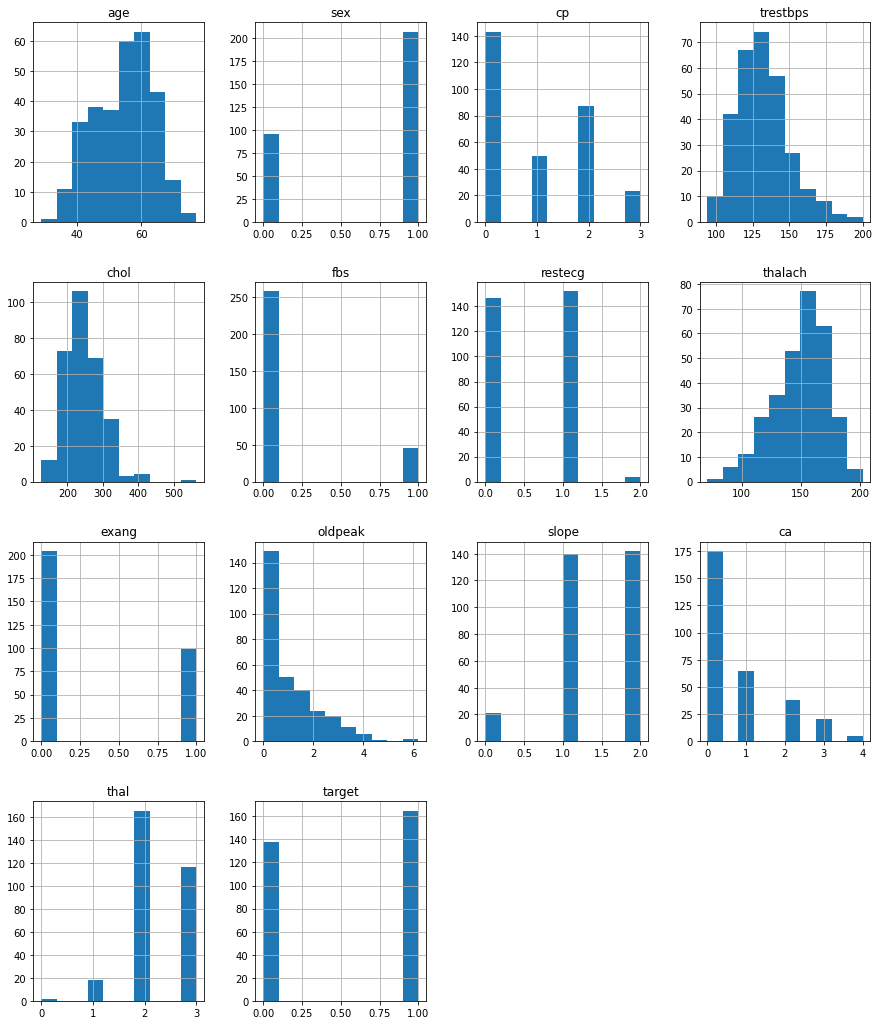

In [10]:
df.hist(figsize=(15,18))
plt.show()

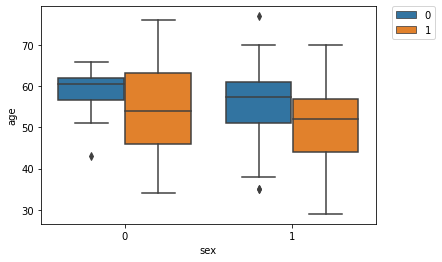

In [11]:
# ulteriori grafici

sns.boxplot(x='sex',y='age',hue='target',data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# e simili
# https://medium.com/swlh/the-framingham-heart-study-decision-trees-83a7fb62718e

In [12]:
# considero la variabile target

df.target.value_counts()


# il dataset non sembra sbilanciato

1    165
0    138
Name: target, dtype: int64

## Analisi correlazione

In [13]:
# Calcolo della correlazione
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


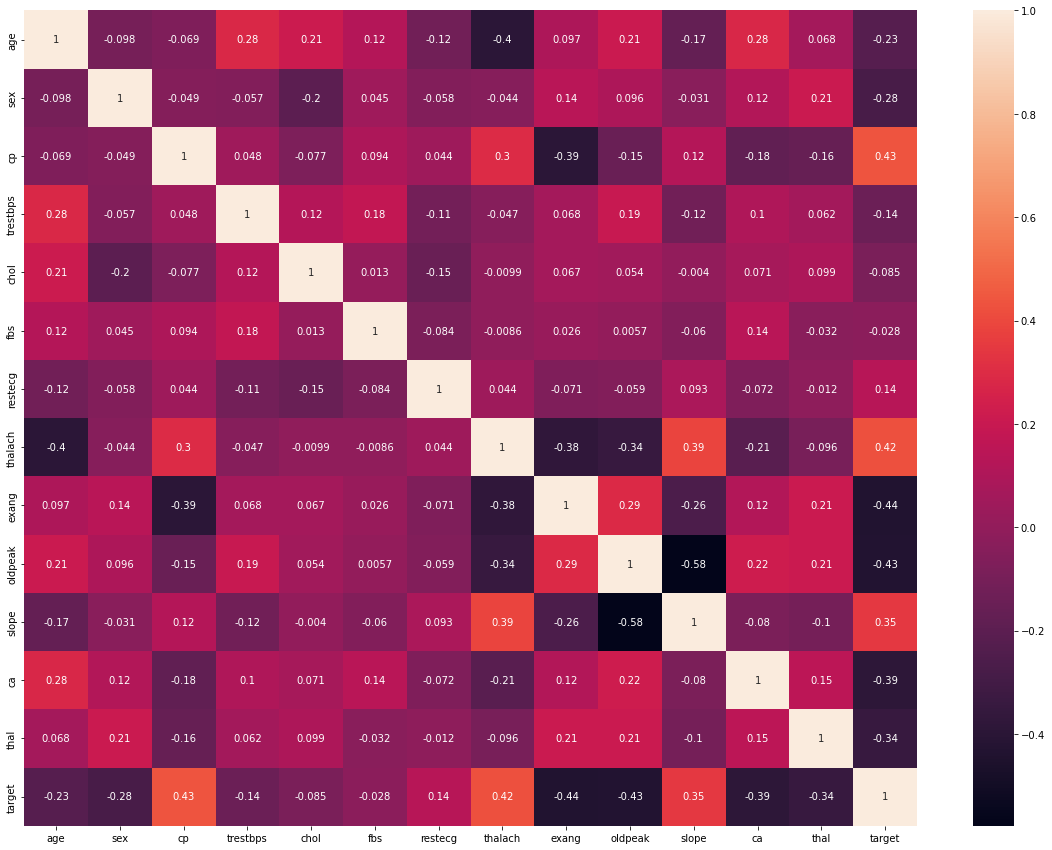

In [14]:
# Visualizzazione della correlazione

f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

# the propensity of developing heart disease is a result of a conjunction of factors.

# It’s easy to see that there is no single feature that has a very high correlation with our target value. Also, some of the features have a negative correlation with the target value and some have positive.

# da questo grafico possiamo dire che non faremo feature selection
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/


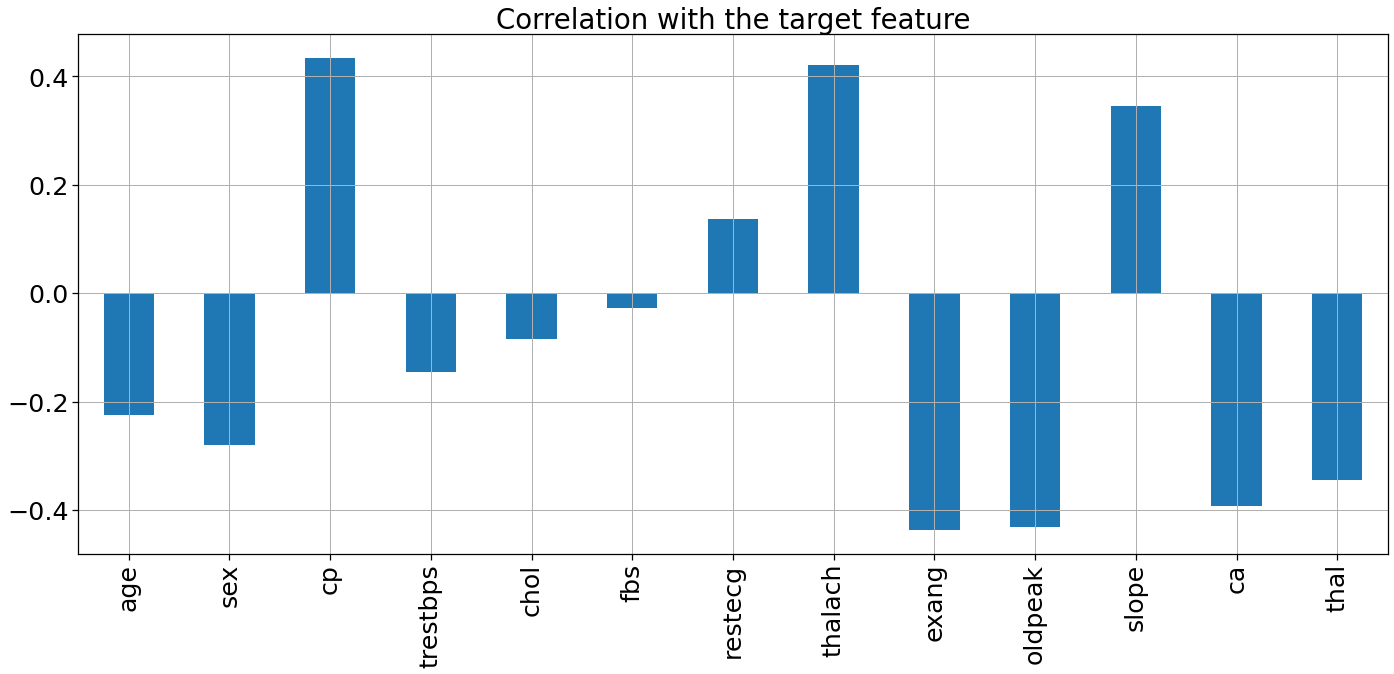

In [15]:
# correlazione variabili con la variabile target
sns.set_context('notebook',font_scale = 2.3)
df.drop('target', axis=1).corrwith(df.target).plot(kind='bar', grid=True, figsize=(20, 10),
                                                        title="Correlation with the target feature")
plt.tight_layout()

# Preprocessing

## Gestione duplicati

In [16]:
# eliminazione duplicati
df = df.drop_duplicates()

## Correzione variabili

In [17]:
# eliminazione feature errate
df = df[df['ca'] < 4] #drop the wrong ca values
df = df[df['thal'] > 0] # drop the wong thal value

## Creazione dummy variables

In [18]:
# Most machine learning algorithms cannot handle categorical variables unless we convert them to numerical values
# Machine learning algorithms cannot process categorical or text data unless they have been converted to numbers. One hot encoding maps categorical values to integer values, which are represented as a binary vector that are all zero values, except the index of the integer, which is set to 1.
# https://towardsdatascience.com/predicting-presence-of-heart-diseases-using-machine-learning-36f00f3edb2c#:~:text=Machine%20Learning%20can%20play%20an,and%20treatment%20per%20patient%20basis.

feature_names = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']

X = df.drop(['target'], axis = 1)

# creo variabili dummy
X = pd.get_dummies(X, columns=['sex','cp','fbs','restecg','exang','slope','ca','thal'])
# è aumentato il numero di collone, 9 feature in più si hanno

y = df.target

In [19]:
X

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
299,45,110,264,132,1.2,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
300,68,144,193,141,3.4,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
301,57,130,131,115,1.2,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1


In [20]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 296, dtype: int64

## Verifica class imbalance

Class 0: 136
Class 1: 160
Proportion: 0.85 : 1


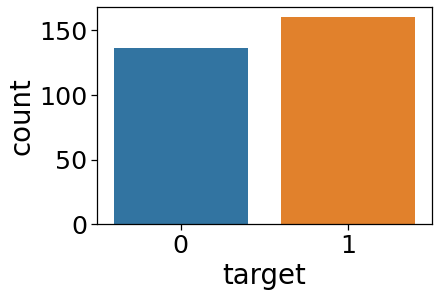

In [21]:
# (su intero dataset)
ax = sns.countplot(x=y)

target_count = df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

## Divisione in train e test

In [22]:
# divide train test: 80 % - 20 %
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

# check sample size
print('X_train: ', X_train.size)
print('y_train: ', y_train.size)
print('X_test: ', X_test.size)
print('y_test: ', y_test.size)

X_train:  6608
y_train:  236
X_test:  1680
y_test:  60


## Scaling

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# faccio lo scaling solo delle variabili non categoriche
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

In [24]:
X_train

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_3
54,0.943549,0.200901,0.121839,0.966057,-0.891222,1,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
268,-0.071184,-0.548022,0.785541,-1.445618,1.909656,0,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
97,-0.296680,-1.354555,-0.249054,-0.110584,-0.803695,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1
267,-0.634925,-0.778460,-1.888789,-1.014962,-0.191003,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,0
257,-0.522177,0.719386,-0.893236,-1.014962,-0.103475,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.522177,-0.663241,-0.034327,0.535400,0.071580,1,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
84,-1.424162,-1.700212,0.375607,-1.187224,-0.366058,1,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
17,1.281793,1.065043,-0.385698,-1.531749,1.384491,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
235,-0.409429,0.488948,1.039310,1.009122,0.509217,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,1


# Feature selection

Per completezza provo ad eseguire feature selection anche se l'implementazione dei modelli prenderà in considerazione tutte le variabili (dal momento in cui dalla matrice di correlazione sopra non si evidenziavano particolari problemi).

## SelectKBest

In [25]:
# in alternativa per avere da 0 a 1 è necessario fare questo scaling e non quello sopra
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

best=SelectKBest(score_func=chi2, k=10)
fit=best.fit(X_train,y_train)
data_scores=pd.DataFrame(fit.scores_)
data_columns=pd.DataFrame(X.columns)

#Join the two dataframes
scores=pd.concat([data_columns,data_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(11,'Score'))

    Feature      Score
27   thal_3  36.500747
7      cp_0  31.175652
26   thal_2  28.578724
17  exang_1  28.560167
21     ca_0  23.017126
20  slope_2  17.533010
19  slope_1  16.615067
9      cp_2  15.979367
23     ca_2  14.809956
5     sex_0  13.844114
16  exang_0  11.800309


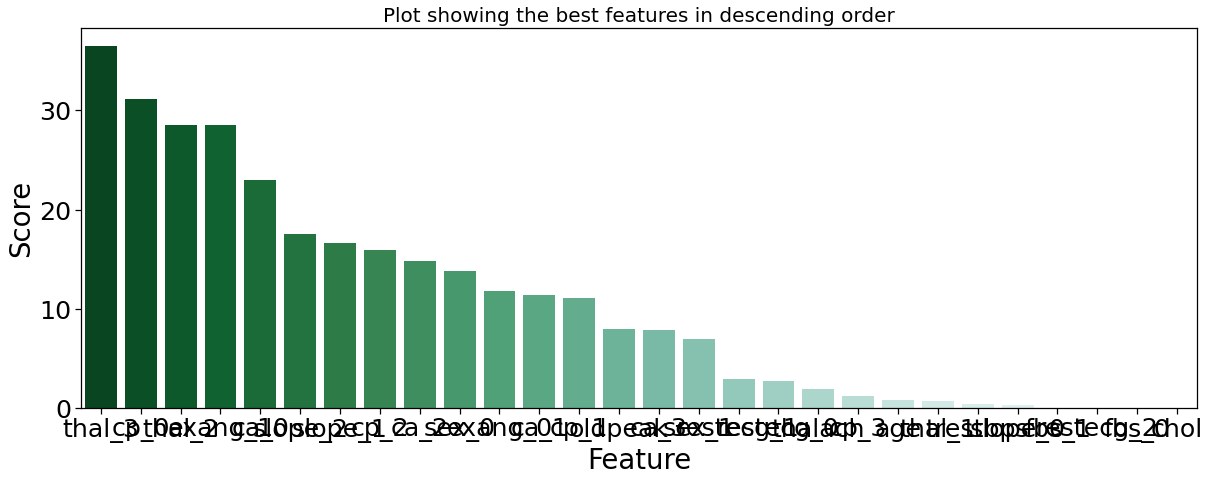

In [26]:
scores=scores.sort_values(by="Score", ascending=False)
plt.figure(figsize=(20,7), facecolor='w')
sns.barplot(x='Feature',y='Score',data=scores,palette='BuGn_r')
plt.title("Plot showing the best features in descending order", size=20)
plt.show()

# alcune variabili potrei escluderle

## ExtraTreesClassifier

[0.05098562 0.04362969 0.04773428 0.05744266 0.05203652 0.02187438
 0.02610949 0.09817467 0.01066178 0.02334041 0.01249541 0.01223885
 0.01224153 0.02068448 0.0212632  0.00109739 0.04024783 0.04082266
 0.00723331 0.03200873 0.04004514 0.10580545 0.02372756 0.01568816
 0.01267353 0.0073077  0.10709795 0.05533162]


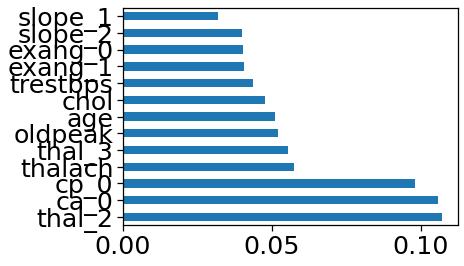

In [27]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')
plt.show()

# Modelli

In [ ]:
# ci concentriamo sulla recall
# Ideally we dont want any false negetives since we want to test for the heart disease.

In [28]:
#loading dataset
import pandas as pd
import numpy as np
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#EDA
from collections import Counter
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

best_accuracies_each_classes = {}

In [29]:
# potrei valutare feature importance prima di applicare tutti i modelli

## Logistic regression

In [ ]:
# %%time
import datetime
from sklearn.model_selection import GridSearchCV
SCORING= 'accuracy'

now = datetime.datetime.now()

# LOGISTIC CLASSIFIER
clf_LOG_REG = LogisticRegression(random_state=123)

# Set the parameters by cross-validation for Logistic Classifier
tuned_parameters_LOG_REG = [
  {'penalty': ['l1'],
   'C':[0.001, .009, 0.01, .09, 1, 5, 10, 25],
   'solver': ['liblinear', 'saga']},
  {'penalty': ['l2'],
   'C':[0.001, .009, 0.01, .09, 1, 5, 10, 25],
   'solver': ['lbfgs', 'sag', 'newton-cg']},
 ]

grid_clf_LOG_REG = GridSearchCV(clf_LOG_REG,
                            param_grid = tuned_parameters_LOG_REG,
                            scoring = SCORING, # perché recall? Find out here: https://stackoverflow.com/questions/61712589/python-scoring-recall-in-gridsearchcv
                            refit='recall',
                            verbose=3)
# cv = cross validation (cv) = 5 --> default
# This number defines the number of folds ((Stratified)KFold) so you split your data automatically 5 times into train and test data

grid_clf_LOG_REG.fit(X_train, y_train)

# Predict values based on new parameters on the X_val dataset
y_pred_LOG_REG = grid_clf_LOG_REG.predict(X_test)

time_stop = datetime.datetime.now()

In [40]:
time_duration_LOG_REG = time_stop - now
print(time_duration_LOG_REG)

0:00:02.006574


              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.88      0.88      0.88        33

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



-------------------------------------
GROUDTRUTH
[1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1
 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0]
PREDICTED
[1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1
 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0]


-------------------------------------


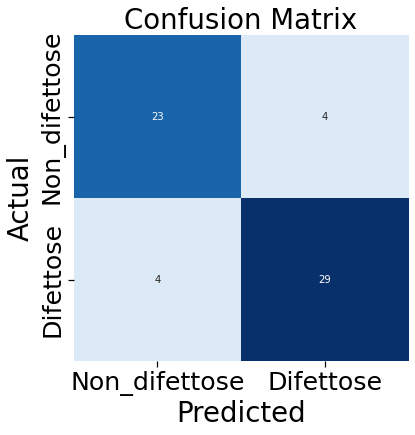



-------------------------------------

 The best estimator across ALL searched params:
 LogisticRegression(C=0.09, penalty='l1', random_state=123, solver='liblinear')

 The best score across ALL searched params:
 0.8515957446808511

 The best parameters across ALL searched params:
 {'C': 0.09, 'penalty': 'l1', 'solver': 'liblinear'}


-------------------------------------
Valore della ROC: 0.8653198653198654


In [41]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


def performance(y_val, y_pred, model, isDummy):

    # Classification report
    print(classification_report(y_val, y_pred))

    # Salva le metriche
    acc = str(accuracy_score(y_val, y_pred))
    prec = str(precision_score(y_val, y_pred))
    rec = str(recall_score(y_val, y_pred))
    f1 = str(f1_score(y_val, y_pred))

    print('\n')
    print('-------------------------------------')

    # Groundtruth vs Predicted
    print('GROUDTRUTH')
    print(np.array(y_val))
    print('PREDICTED')
    print(y_pred)

    print('\n')
    print('-------------------------------------')

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    clr = classification_report(y_val,
                                y_pred,
                                labels=model.classes_)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=['Non_difettose', 'Difettose'])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=['Non_difettose', 'Difettose'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print('\n')
    print('-------------------------------------')

    # Best parameters
    if isDummy:
        best_est = 0
        best_score = 0
        best_para = 0
    else:
        best_est = model.best_estimator_
        best_score = model.best_score_  # Mean cross-validated score of the best_estimator. For multi-metric evaluation, this is present only if refit is specified.
        best_para = model.best_params_

    print("\n The best estimator across ALL searched params:\n", best_est)
    print("\n The best score across ALL searched params:\n", best_score)
    print("\n The best parameters across ALL searched params:\n", best_para)

    print('\n')
    print('-------------------------------------')

    # ROC value
    roc = roc_auc_score(y_val, y_pred)
    print("Valore della ROC:", roc)

    return acc, prec, rec, f1, best_est, best_score, best_para, roc

acc_LOG_REG, prec_LOG_REG, rec_LOG_REG, f1_LOG_REG, best_est_LOG_REG, best_score_LOG_REG, best_para_LOG_REG, roc_LOG_REG  = performance(y_test, y_pred_LOG_REG, grid_clf_LOG_REG, False)


In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

best_accuracies_each_classes['LR'] = str(lr_acc_score*100)

confussion matrix
[[24  3]
 [ 5 28]]


Accuracy of Logistic Regression: 86.66666666666667 

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.90      0.85      0.88        33

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



## Naive Bayes

In [80]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

best_accuracies_each_classes['NB'] = nb_acc_score*100

confussion matrix
[[24  3]
 [ 6 27]]


Accuracy of Naive Bayes model: 85.0 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.90      0.82      0.86        33

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



## Decision Tree

In [86]:
m3 = 'Decision Tree'
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of Decision Tree:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

best_accuracies_each_classes['DT'] = dt_acc_score*100

confussion matrix
[[23  4]
 [ 7 26]]


Accuracy of Decision Tree: 81.66666666666667 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        27
           1       0.87      0.79      0.83        33

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



## Ranndom Forest

In [82]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

best_accuracies_each_classes['RF'] = rf_acc_score*100

confussion matrix
[[24  3]
 [ 4 29]]


Accuracy of Random Forest: 88.33333333333333 

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.91      0.88      0.89        33

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



## KNN

Best Test KNN Score accuracy is: 88.33


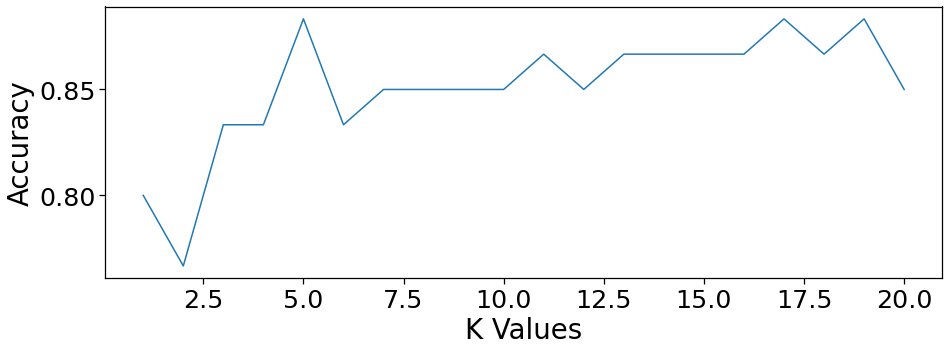

In [83]:
score_list_test = []
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    score_list_test.append(knn.score(X_test,y_test))

print("Best Test KNN Score accuracy is: {:.2f}".format(max(score_list_test)*100))

plt.figure(figsize=(15,5))
plt.plot(range(1,21),score_list_test)
plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.show()

best_accuracies_each_classes['KNN'] = max(score_list_test)*100

## SVM

In [84]:
m2 = 'SVM'
svm = SVC(random_state = 1)
svm.fit(X_train,y_train)
svmpred = svm.predict(X_test)
svm_conf_matrix = confusion_matrix(y_test, nbpred)
svm_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(svm_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",svm_acc_score*100,'\n')
print(classification_report(y_test,svmpred))

best_accuracies_each_classes['SVM'] = svm_acc_score*100

confussion matrix
[[24  3]
 [ 6 27]]


Accuracy of Naive Bayes model: 85.0 

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        27
           1       0.87      0.82      0.84        33

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



## Comparazione modelli

In [87]:
best_accuracies_each_classes

{'LR': '86.66666666666667',
 'NB': 85.0,
 'DT': 81.66666666666667,
 'RF': 88.33333333333333,
 'KNN': 88.33333333333333,
 'SVM': 85.0}

<Figure size 720x360 with 0 Axes>

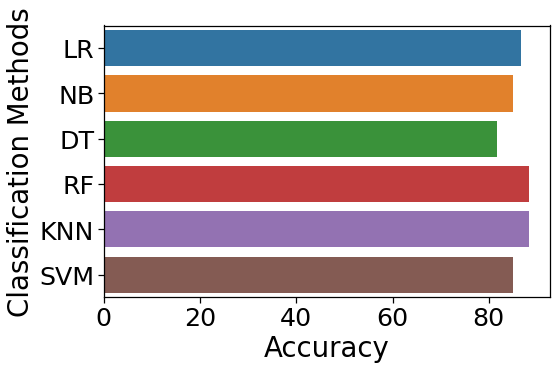

In [111]:
plt.figure(figsize=(10,5))
df = pd.DataFrame({'model':list(best_accuracies_each_classes.keys()), 'val':list(best_accuracies_each_classes.values())})
df['val'] = df['val'].astype(float)
plt.figure(figsize=(8,5))
sns.barplot( y= df['model'], x=df['val'])
plt.xlabel("Accuracy")
plt.ylabel("Classification Methods")
plt.show()